# 現実写真のみ、文字なし、固有名詞含む、キャプション、ほかの画像の大喜利

In [1]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.utils.data import Dataset, DataLoader

In [2]:
EXPERIENCE_NUMBER = "003"

USE_UNREAL_IMAGE = False
USE_WORD_IMAGE = False
USE_UNIQUE_NOUN_BOKE = True
USE_CAPTION = True
USE_MISS_BOKE = True

EPOCH = 25
BATCH_SIZE = 256

RESULT_DIR = f"../../results/Boke_Judge/{EXPERIENCE_NUMBER}/"
if not os.path.exists("../../results/Boke_Judge/"):
    os.mkdir("../../results/Boke_Judge/")
if not os.path.exists(RESULT_DIR):
    os.mkdir(RESULT_DIR)

DATA_DIR = "../../datas/boke_data_assemble/"
CLIP_IMAGE_FEATURE_DIR = "../../datas/encoded/clip_image_feature/"
CLIP_SENTENCE_FEATURE_DIR = "../../datas/encoded/clip_sentence_feature/"
LUKE_SENTENCE_FEATURE_DIR = "../../datas/encoded/luke_sentence_feature/"

# データセットの作成(初回のみ実行)

In [3]:
boke_datas = list()
caption_datas = list()

max_num_boke = 0
for JP in tqdm(os.listdir(DATA_DIR)):
    N = int(JP.split(".")[0])

    with open(f"{DATA_DIR}{JP}", "r") as f:
        a = json.load(f)

    image_information = a["image_infomation"]
    is_photographic_probability = image_information["is_photographic_probability"]
    ja_caption = image_information["ja_caption"]
    ocr = image_information["ocr"]

    # 現実写真以外を除去
    if not USE_UNREAL_IMAGE:
        if is_photographic_probability < 0.8: continue
        
    # 文字のある画像を除去
    if not USE_WORD_IMAGE:
        if len(ocr) != 0: continue

    bokes = a["bokes"]

    max_num_boke = max(max_num_boke, len(a["bokes"]))
    for i, B in enumerate(bokes):

        # 固有名詞を含む大喜利を除去
        if not USE_UNIQUE_NOUN_BOKE:
            if len(B["unique_nouns"]) != 0: continue

        boke_datas.append({
            "boke_number": int(f"1{N:07}{i:05}"),
            "image_number": int(f"3{N:07}")
        })

    caption_datas.append({
        "caption_number": int(f"2{N:07}"),
        "image_number": int(f"3{N:07}")
    })

len(boke_datas), len(caption_datas)

100%|██████████| 602566/602566 [03:21<00:00, 2996.06it/s]


(4480885, 230990)

In [4]:
train_boke_datas, test_boke_datas = train_test_split(boke_datas, test_size = 0.01)
train_caption_datas, test_caption_datas = train_test_split(caption_datas, test_size = 0.01)

with open(f"{RESULT_DIR}train_boke_datas.json", "w") as f:
    json.dump(train_boke_datas, f)
with open(f"{RESULT_DIR}train_caption_datas.json", "w") as f:
    json.dump(train_caption_datas, f)

with open(f"{RESULT_DIR}test_boke_datas.json", "w") as f:
    json.dump(test_boke_datas, f)
with open(f"{RESULT_DIR}test_caption_datas.json", "w") as f:
    json.dump(test_caption_datas, f)

# モデルの学習

In [5]:
with open(f"{RESULT_DIR}train_boke_datas.json", "r") as f:
    train_boke_datas = json.load(f)
with open(f"{RESULT_DIR}train_caption_datas.json", "r") as f:
    train_caption_datas = json.load(f)

with open(f"{RESULT_DIR}test_boke_datas.json", "r") as f:
    test_boke_datas = json.load(f)
with open(f"{RESULT_DIR}test_caption_datas.json", "r") as f:
    test_caption_datas = json.load(f)

len(train_boke_datas), len(train_caption_datas), len(test_boke_datas), len(test_caption_datas)

(4436076, 228680, 44809, 2310)

In [6]:
def make_dataloader(boke_datas, caption_datas):
    class LoadNpyDataset(Dataset):
        def __init__(self, image_file_numbers, sentence_file_numbers, teacher_signals):
            if len(image_file_numbers) != len(sentence_file_numbers) and len(sentence_file_numbers) != len(teacher_signals):
                raise ValueError("データリストの長さが一致しません")

            self.image_file_numbers = image_file_numbers
            self.sentence_file_numbers = sentence_file_numbers
            self.teacher_signals = teacher_signals

        def __len__(self):
            return len(self.teacher_signals)

        def __getitem__(self, idx):
            clip_image_feature = np.load(f"{CLIP_IMAGE_FEATURE_DIR}{self.image_file_numbers[idx]}.npy")
            clip_sentence_feature = np.load(f"{CLIP_SENTENCE_FEATURE_DIR}{self.sentence_file_numbers[idx]}.npy")
            luke_sentence_feature = np.load(f"{LUKE_SENTENCE_FEATURE_DIR}{self.sentence_file_numbers[idx]}.npy")
            teacher_signal = self.teacher_signals[idx]

            return clip_image_feature, clip_sentence_feature, luke_sentence_feature, teacher_signal

    def collate_fn_tf(batch):
        clip_image_features = np.array([B[0] for B in batch])
        clip_sentence_features = np.array([B[1] for B in batch])
        luke_sentence_features = np.array([B[2] for B in batch])
        teacher_signals = np.array([float(B[3]) for B in batch])
        
        return clip_image_features, clip_sentence_features, luke_sentence_features, teacher_signals

    #
    image_file_numbers = list()
    sentence_file_numbers = list()
    teacher_signals = list()

    for D in boke_datas:
        image_file_numbers.append(D["image_number"])
        sentence_file_numbers.append(D["boke_number"])
        teacher_signals.append(1)

    if USE_CAPTION:
        for D in caption_datas:
            image_file_numbers.append(D["image_number"])
            sentence_file_numbers.append(D["caption_number"])
            teacher_signals.append(0)
    
    if USE_MISS_BOKE:
        miss_boke_datas = list()
        tmp_idx = np.random.randint(0, len(boke_datas), size = (len(boke_datas), ))
        for i, idx in tqdm(enumerate(tmp_idx)):
            tmp_boke_number = boke_datas[idx]["boke_number"]
            while str(tmp_boke_number)[:7] == str(boke_datas[i]["boke_number"])[:7]:
                idx = np.random.randint(0, len(boke_datas))
                tmp_boke_number = boke_datas[idx]["boke_number"]

            miss_boke_datas.append({
                "boke_number": tmp_boke_number,
                "image_number": boke_datas[i]["image_number"]
            })
        
        for D in miss_boke_datas:
            image_file_numbers.append(D["image_number"])
            sentence_file_numbers.append(D["boke_number"])
            teacher_signals.append(0)
    
    print(f"num data: {len(teacher_signals)}")

    tmp = list(zip(image_file_numbers, sentence_file_numbers, teacher_signals))
    np.random.shuffle(tmp)
    image_file_numbers, sentence_file_numbers, teacher_signals = zip(*tmp)

    dataset = LoadNpyDataset(image_file_numbers, sentence_file_numbers, teacher_signals)
    dataloader = DataLoader(
        dataset, 
        batch_size = BATCH_SIZE, 
        num_workers = 10, 
        collate_fn = collate_fn_tf
    )

    return dataloader

train_dataloader = make_dataloader(train_boke_datas, train_caption_datas)
test_dataloader = make_dataloader(test_boke_datas, test_caption_datas)

#
CIF, CSF, LSF, TS = next(iter(train_dataloader))
CIF.shape, CSF.shape, LSF.shape, TS.shape

4436076it [00:04, 1050309.06it/s]


num data: 9100832


44809it [00:00, 83832.20it/s]

num data: 91928


((256, 512), (256, 512), (256, 768), (256,))

In [7]:
class CustomModel(nn.Module):
    def __init__(self, cif_dim, csf_dim, lsf_dim):
        super(CustomModel, self).__init__()
        # 入力次元を設定
        self.cif_dim = cif_dim
        self.csf_dim = csf_dim
        self.lsf_dim = lsf_dim
        
        # 全結合層
        self.fc1 = nn.Linear(cif_dim + csf_dim + lsf_dim, 1024)
        self.fc2 = nn.Linear(1024, 1024)
        self.fc3 = nn.Linear(1024, 1024)
        self.output_layer = nn.Linear(1024, 1)
        
    def forward(self, cif, csf, lsf):
        # 入力を結合
        x = torch.cat([cif, csf, lsf], dim=1)
        # 全結合層 + LeakyReLU
        x = F.leaky_relu(self.fc1(x))
        x = F.leaky_relu(self.fc2(x))
        x = F.leaky_relu(self.fc3(x))
        # 出力層 + シグモイド
        output = torch.sigmoid(self.output_layer(x))
        return output

model = CustomModel(CIF.shape[1], CSF.shape[1], LSF.shape[1])
print(model)

CustomModel(
  (fc1): Linear(in_features=1792, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=1024, bias=True)
  (fc3): Linear(in_features=1024, out_features=1024, bias=True)
  (output_layer): Linear(in_features=1024, out_features=1, bias=True)
)


In [8]:
def train_step(model, optimizer, batch_data, batch_labels):
    model.train()  # モデルを訓練モードに設定
    optimizer.zero_grad()  # 勾配を初期化
    outputs = model(*batch_data).float()  # モデルで予測を計算
    loss = nn.BCELoss()(outputs, batch_labels.float())  # 損失関数（バイナリクロスエントロピー）
    accuracy = ((outputs > 0.5).float() == batch_labels).float().mean()  # 精度計算
    loss.backward()  # 勾配を計算
    optimizer.step()  # パラメータ更新
    return loss.item(), accuracy.item()

def evaluate(model, batch_data, batch_labels):
    model.eval()  # モデルを評価モードに設定
    with torch.no_grad():  # 評価時に勾配計算を行わない
        outputs = model(*batch_data)
        loss = nn.BCELoss()(outputs, batch_labels)
        accuracy = ((outputs > 0.5).float() == batch_labels).float().mean()
    return loss.item(), accuracy.item()

train_loss_history = []
train_accuracy_history = []
test_loss_history = []
test_accuracy_history = []

model = CustomModel(CIF.shape[1], CSF.shape[1], LSF.shape[1])
optimizer = optim.AdamW(model.parameters(), lr = 0.0001)

# 訓練・評価ループ
for epoch in range(EPOCH):
    # 訓練
    train_loss_obj = 0.0
    train_accuracy_obj = 0.0
    model.train()  # 訓練モード
    train_dataloader = make_dataloader(train_boke_datas, train_caption_datas)
    pb = tqdm(train_dataloader, desc = f"Epoch {epoch+1}/{EPOCH}")
    
    for CIF, CSF, LSF, TS in pb:
        CIF, CSF, LSF, TS = torch.tensor(CIF), torch.tensor(CSF), torch.tensor(LSF), torch.tensor(TS)
        batch_data = (CIF, CSF, LSF)  # 入力データ
        batch_labels = TS.unsqueeze(1)  # 出力ラベル（shape: [batch_size, 1]）
        
        loss, accuracy = train_step(model, optimizer, batch_data, batch_labels)
        train_loss_obj += loss
        train_accuracy_obj += accuracy
        pb.set_postfix({"train_loss": train_loss_obj / (pb.n + 1), "train_accuracy": train_accuracy_obj / (pb.n + 1)})

    # 訓練後の損失と精度
    train_loss = train_loss_obj / len(train_dataloader)
    train_accuracy = train_accuracy_obj / len(train_dataloader)

    # テスト
    test_loss_obj = 0.0
    test_accuracy_obj = 0.0
    model.eval()  # 評価モード
    test_dataloader = make_dataloader(test_boke_datas, test_caption_datas)
    pb = tqdm(test_dataloader, desc = "Evaluating")

    for CIF, CSF, LSF, TS in pb:
        CIF, CSF, LSF, TS = torch.tensor(CIF).float(), torch.tensor(CSF).float(), torch.tensor(LSF).float(), torch.tensor(TS).float()
        batch_data = (CIF, CSF, LSF)
        batch_labels = TS.unsqueeze(1).float()
        
        loss, accuracy = evaluate(model, batch_data, batch_labels)
        test_loss_obj += loss
        test_accuracy_obj += accuracy
        pb.set_postfix({"test_loss": test_loss_obj / (pb.n + 1), "test_accuracy": test_accuracy_obj / (pb.n + 1)})

    # テスト後の損失と精度
    test_loss = test_loss_obj / len(test_dataloader)
    test_accuracy = test_accuracy_obj / len(test_dataloader)

    # 結果表示
    print(f"Epoch: {epoch+1}/{EPOCH}, "
          f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, "
          f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

    # 履歴の保存
    train_loss_history.append(train_loss)
    train_accuracy_history.append(train_accuracy)
    test_loss_history.append(test_loss)
    test_accuracy_history.append(test_accuracy)

# 結果をJSONファイルに保存
with open(f"{RESULT_DIR}history.json", "w") as f:
    json.dump({
        "train_loss": train_loss_history,
        "train_accuracy": train_accuracy_history,
        "test_loss": test_loss_history,
        "test_accuracy": test_accuracy_history
    }, f)


4436076it [00:04, 1057188.21it/s]


num data: 9100832


Epoch 1/25: 100%|██████████| 35551/35551 [20:34<00:00, 28.79it/s, train_loss=0.594, train_accuracy=0.667]
44809it [00:00, 1238183.06it/s]


num data: 91928


Evaluating: 100%|██████████| 360/360 [00:05<00:00, 66.12it/s, test_loss=0.574, test_accuracy=0.707] 


Epoch: 1/25, Train Loss: 0.5935, Train Accuracy: 0.6670, Test Loss: 0.5647, Test Accuracy: 0.6954


4436076it [00:04, 1052505.51it/s]


num data: 9100832


Epoch 2/25: 100%|██████████| 35551/35551 [14:02<00:00, 42.22it/s, train_loss=0.556, train_accuracy=0.703]  
44809it [00:00, 1268776.32it/s]


num data: 91928


Evaluating: 100%|██████████| 360/360 [00:05<00:00, 66.01it/s, test_loss=0.562, test_accuracy=0.724] 


Epoch: 2/25, Train Loss: 0.5564, Train Accuracy: 0.7026, Test Loss: 0.5500, Test Accuracy: 0.7082


4436076it [00:04, 1062822.76it/s]


num data: 9100832


Epoch 3/25: 100%|██████████| 35551/35551 [14:09<00:00, 41.85it/s, train_loss=0.539, train_accuracy=0.717] 
44809it [00:00, 1289724.81it/s]


num data: 91928


Evaluating: 100%|██████████| 360/360 [00:05<00:00, 65.93it/s, test_loss=0.552, test_accuracy=0.728] 


Epoch: 3/25, Train Loss: 0.5391, Train Accuracy: 0.7165, Test Loss: 0.5414, Test Accuracy: 0.7135


4436076it [00:04, 1003973.44it/s]


num data: 9100832


Epoch 4/25: 100%|██████████| 35551/35551 [18:22<00:00, 32.24it/s, train_loss=0.527, train_accuracy=0.726] 
44809it [00:00, 1281703.33it/s]


num data: 91928


Evaluating: 100%|██████████| 360/360 [00:06<00:00, 51.78it/s, test_loss=0.549, test_accuracy=0.742] 


Epoch: 4/25, Train Loss: 0.5270, Train Accuracy: 0.7262, Test Loss: 0.5336, Test Accuracy: 0.7211


4436076it [00:04, 1021185.85it/s]


num data: 9100832


Epoch 5/25: 100%|██████████| 35551/35551 [17:49<00:00, 33.23it/s, train_loss=0.517, train_accuracy=0.733]  
44809it [00:00, 1131740.99it/s]


num data: 91928


Evaluating: 100%|██████████| 360/360 [00:05<00:00, 65.54it/s, test_loss=0.544, test_accuracy=0.746] 


Epoch: 5/25, Train Loss: 0.5172, Train Accuracy: 0.7334, Test Loss: 0.5288, Test Accuracy: 0.7248


4436076it [00:04, 1053363.96it/s]


num data: 9100832


Epoch 6/25: 100%|██████████| 35551/35551 [15:09<00:00, 39.10it/s, train_loss=0.509, train_accuracy=0.739]
44809it [00:00, 1349289.74it/s]


num data: 91928


Evaluating: 100%|██████████| 360/360 [00:05<00:00, 66.00it/s, test_loss=0.537, test_accuracy=0.745] 


Epoch: 6/25, Train Loss: 0.5090, Train Accuracy: 0.7393, Test Loss: 0.5249, Test Accuracy: 0.7287


4436076it [00:04, 1051456.67it/s]


num data: 9100832


Epoch 7/25: 100%|██████████| 35551/35551 [13:36<00:00, 43.54it/s, train_loss=0.502, train_accuracy=0.744]
44809it [00:00, 1206864.33it/s]


num data: 91928


Evaluating: 100%|██████████| 360/360 [00:05<00:00, 63.93it/s, test_loss=0.54, test_accuracy=0.754]  


Epoch: 7/25, Train Loss: 0.5017, Train Accuracy: 0.7443, Test Loss: 0.5238, Test Accuracy: 0.7314


4436076it [00:04, 1069481.71it/s]


num data: 9100832


Epoch 8/25: 100%|██████████| 35551/35551 [14:02<00:00, 42.19it/s, train_loss=0.496, train_accuracy=0.749]
44809it [00:00, 1246758.22it/s]


num data: 91928


Evaluating: 100%|██████████| 360/360 [00:05<00:00, 63.98it/s, test_loss=0.53, test_accuracy=0.741]  


Epoch: 8/25, Train Loss: 0.4955, Train Accuracy: 0.7487, Test Loss: 0.5229, Test Accuracy: 0.7312


4436076it [00:04, 1031623.06it/s]


num data: 9100832


Epoch 9/25: 100%|██████████| 35551/35551 [14:23<00:00, 41.15it/s, train_loss=0.49, train_accuracy=0.753] 
44809it [00:00, 1254899.73it/s]


num data: 91928


Evaluating: 100%|██████████| 360/360 [00:05<00:00, 63.50it/s, test_loss=0.54, test_accuracy=0.756]  


Epoch: 9/25, Train Loss: 0.4896, Train Accuracy: 0.7526, Test Loss: 0.5232, Test Accuracy: 0.7327


4436076it [00:04, 1065499.34it/s]


num data: 9100832


Epoch 10/25: 100%|██████████| 35551/35551 [16:10<00:00, 36.64it/s, train_loss=0.485, train_accuracy=0.756]  
44809it [00:00, 1196255.90it/s]


num data: 91928


Evaluating: 100%|██████████| 360/360 [00:05<00:00, 64.35it/s, test_loss=0.527, test_accuracy=0.744] 


Epoch: 10/25, Train Loss: 0.4845, Train Accuracy: 0.7559, Test Loss: 0.5201, Test Accuracy: 0.7336


4436076it [00:04, 1050579.37it/s]


num data: 9100832


Epoch 11/25: 100%|██████████| 35551/35551 [16:02<00:00, 36.93it/s, train_loss=0.479, train_accuracy=0.759]
44809it [00:00, 1247229.83it/s]


num data: 91928


Evaluating: 100%|██████████| 360/360 [00:05<00:00, 63.83it/s, test_loss=0.529, test_accuracy=0.75]  


Epoch: 11/25, Train Loss: 0.4794, Train Accuracy: 0.7594, Test Loss: 0.5186, Test Accuracy: 0.7357


4436076it [00:04, 1066508.90it/s]


num data: 9100832


Epoch 12/25: 100%|██████████| 35551/35551 [16:16<00:00, 36.39it/s, train_loss=0.475, train_accuracy=0.762]
44809it [00:00, 1323679.04it/s]


num data: 91928


Evaluating: 100%|██████████| 360/360 [00:05<00:00, 64.58it/s, test_loss=0.53, test_accuracy=0.749]  


Epoch: 12/25, Train Loss: 0.4748, Train Accuracy: 0.7622, Test Loss: 0.5208, Test Accuracy: 0.7368


4436076it [00:04, 1053317.39it/s]


num data: 9100832


Epoch 13/25: 100%|██████████| 35551/35551 [15:52<00:00, 37.33it/s, train_loss=0.471, train_accuracy=0.765]
44809it [00:00, 1317249.81it/s]


num data: 91928


Evaluating: 100%|██████████| 360/360 [00:05<00:00, 66.26it/s, test_loss=0.541, test_accuracy=0.763] 


Epoch: 13/25, Train Loss: 0.4707, Train Accuracy: 0.7648, Test Loss: 0.5215, Test Accuracy: 0.7355


4436076it [00:04, 1060488.54it/s]


num data: 9100832


Epoch 14/25: 100%|██████████| 35551/35551 [16:44<00:00, 35.39it/s, train_loss=0.467, train_accuracy=0.767]
44809it [00:00, 1279321.53it/s]


num data: 91928


Evaluating: 100%|██████████| 360/360 [00:05<00:00, 64.02it/s, test_loss=0.541, test_accuracy=0.758] 


Epoch: 14/25, Train Loss: 0.4667, Train Accuracy: 0.7672, Test Loss: 0.5241, Test Accuracy: 0.7346


4436076it [00:04, 1052157.39it/s]


num data: 9100832


Epoch 15/25: 100%|██████████| 35551/35551 [16:43<00:00, 35.44it/s, train_loss=0.463, train_accuracy=0.77]   
44809it [00:00, 1200381.74it/s]


num data: 91928


Evaluating: 100%|██████████| 360/360 [00:05<00:00, 64.00it/s, test_loss=0.539, test_accuracy=0.752] 


Epoch: 15/25, Train Loss: 0.4629, Train Accuracy: 0.7695, Test Loss: 0.5270, Test Accuracy: 0.7348


4436076it [00:04, 1103013.29it/s]


num data: 9100832


Epoch 16/25: 100%|██████████| 35551/35551 [16:56<00:00, 34.98it/s, train_loss=0.46, train_accuracy=0.772] 
44809it [00:00, 1270869.72it/s]


num data: 91928


Evaluating: 100%|██████████| 360/360 [00:05<00:00, 66.21it/s, test_loss=0.543, test_accuracy=0.76]  


Epoch: 16/25, Train Loss: 0.4596, Train Accuracy: 0.7716, Test Loss: 0.5265, Test Accuracy: 0.7370


4436076it [00:04, 1050456.60it/s]


num data: 9100832


Epoch 17/25: 100%|██████████| 35551/35551 [17:12<00:00, 34.43it/s, train_loss=0.456, train_accuracy=0.774]
44809it [00:00, 1245816.08it/s]


num data: 91928


Evaluating: 100%|██████████| 360/360 [00:05<00:00, 65.33it/s, test_loss=0.542, test_accuracy=0.759] 


Epoch: 17/25, Train Loss: 0.4564, Train Accuracy: 0.7736, Test Loss: 0.5265, Test Accuracy: 0.7375


4436076it [00:04, 1072339.48it/s]


num data: 9100832


Epoch 18/25: 100%|██████████| 35551/35551 [20:50<00:00, 28.43it/s, train_loss=0.453, train_accuracy=0.776]  
44809it [00:00, 1327249.90it/s]


num data: 91928


Evaluating: 100%|██████████| 360/360 [00:05<00:00, 65.37it/s, test_loss=0.534, test_accuracy=0.747] 


Epoch: 18/25, Train Loss: 0.4533, Train Accuracy: 0.7755, Test Loss: 0.5269, Test Accuracy: 0.7363


4436076it [00:04, 1061880.46it/s]


num data: 9100832


Epoch 19/25: 100%|██████████| 35551/35551 [17:55<00:00, 33.04it/s, train_loss=0.45, train_accuracy=0.777] 
44809it [00:00, 1352367.50it/s]


num data: 91928


Evaluating: 100%|██████████| 360/360 [00:05<00:00, 67.50it/s, test_loss=0.544, test_accuracy=0.757] 


Epoch: 19/25, Train Loss: 0.4504, Train Accuracy: 0.7772, Test Loss: 0.5303, Test Accuracy: 0.7381


4436076it [00:04, 1084618.66it/s]


num data: 9100832


Epoch 20/25: 100%|██████████| 35551/35551 [17:48<00:00, 33.27it/s, train_loss=0.448, train_accuracy=0.779]  
44809it [00:00, 1389439.75it/s]


num data: 91928


Evaluating: 100%|██████████| 360/360 [00:05<00:00, 64.82it/s, test_loss=0.536, test_accuracy=0.742] 


Epoch: 20/25, Train Loss: 0.4477, Train Accuracy: 0.7789, Test Loss: 0.5328, Test Accuracy: 0.7374


4436076it [00:04, 1092633.04it/s]


num data: 9100832


Epoch 21/25: 100%|██████████| 35551/35551 [17:32<00:00, 33.78it/s, train_loss=0.445, train_accuracy=0.78] 
44809it [00:00, 1303816.69it/s]


num data: 91928


Evaluating: 100%|██████████| 360/360 [00:05<00:00, 61.25it/s, test_loss=0.539, test_accuracy=0.744] 


Epoch: 21/25, Train Loss: 0.4452, Train Accuracy: 0.7805, Test Loss: 0.5326, Test Accuracy: 0.7359


4436076it [00:04, 1084982.39it/s]


num data: 9100832


Epoch 22/25: 100%|██████████| 35551/35551 [18:48<00:00, 31.50it/s, train_loss=0.443, train_accuracy=0.782]  
44809it [00:00, 1337802.83it/s]


num data: 91928


Evaluating: 100%|██████████| 360/360 [00:05<00:00, 66.22it/s, test_loss=0.546, test_accuracy=0.751] 


Epoch: 22/25, Train Loss: 0.4427, Train Accuracy: 0.7819, Test Loss: 0.5357, Test Accuracy: 0.7367


4436076it [00:04, 1038894.73it/s]


num data: 9100832


Epoch 23/25: 100%|██████████| 35551/35551 [16:21<00:00, 36.23it/s, train_loss=0.44, train_accuracy=0.783] 
44809it [00:00, 1295342.70it/s]


num data: 91928


Evaluating: 100%|██████████| 360/360 [00:05<00:00, 64.01it/s, test_loss=0.557, test_accuracy=0.761] 


Epoch: 23/25, Train Loss: 0.4404, Train Accuracy: 0.7833, Test Loss: 0.5387, Test Accuracy: 0.7361


4436076it [00:04, 1085658.14it/s]


num data: 9100832


Epoch 24/25: 100%|██████████| 35551/35551 [17:11<00:00, 34.46it/s, train_loss=0.438, train_accuracy=0.785]
44809it [00:00, 1273039.01it/s]


num data: 91928


Evaluating: 100%|██████████| 360/360 [00:05<00:00, 62.46it/s, test_loss=0.556, test_accuracy=0.76]  


Epoch: 24/25, Train Loss: 0.4379, Train Accuracy: 0.7847, Test Loss: 0.5371, Test Accuracy: 0.7348


4436076it [00:04, 1070402.70it/s]


num data: 9100832


Epoch 25/25: 100%|██████████| 35551/35551 [17:08<00:00, 34.55it/s, train_loss=0.436, train_accuracy=0.786]
44809it [00:00, 1329794.87it/s]


num data: 91928


Evaluating: 100%|██████████| 360/360 [00:05<00:00, 64.56it/s, test_loss=0.546, test_accuracy=0.744] 


Epoch: 25/25, Train Loss: 0.4361, Train Accuracy: 0.7859, Test Loss: 0.5397, Test Accuracy: 0.7360


In [ ]:
torch.save(model.state_dict(), f"{RESULT_DIR}model_weights.pth")

model = CustomModel(CIF.shape[1], CSF.shape[1], LSF.shape[1])
model.load_state_dict(torch.load(f"{RESULT_DIR}model_weights.pth",
                                 map_location=torch.device('cpu')))
model.eval()

<ipython-input-10-a5555dbdb8e2>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f"{RESULT_DIR}model_weights.pth",


CustomModel(
  (fc1): Linear(in_features=1792, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=1024, bias=True)
  (fc3): Linear(in_features=1024, out_features=1024, bias=True)
  (output_layer): Linear(in_features=1024, out_features=1, bias=True)
)

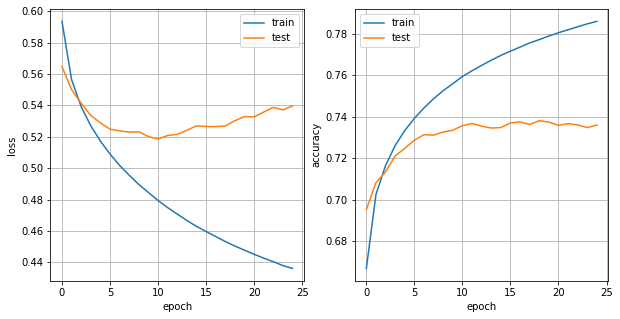

In [9]:
fig = plt.figure(figsize = (10, 5))
ax = fig.add_subplot(1, 2, 1)
ax.plot(train_loss_history, label = "train")
ax.plot(test_loss_history, label = "test")
ax.set_xlabel("epoch")
ax.set_ylabel("loss")
ax.legend()
ax.grid()

ax = fig.add_subplot(1, 2, 2)
ax.plot(train_accuracy_history, label = "train")
ax.plot(test_accuracy_history, label = "test")
ax.set_xlabel("epoch")
ax.set_ylabel("accuracy")
ax.legend()
ax.grid()